In [16]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem
from matplotlib.backends.backend_pdf import PdfPages


functions

In [2]:
def convergence_test(fval, previous_fval, threshold=1e-4, warn=False):
    """
    Check if an objective function has converged.

    We have converged if the slope of the function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2.
    'threshold' defaults to 1e-4.
    This stopping criterion is from Numerical Recipes in C p423.
    """

    converged = False
    delta_fval = np.abs(fval - previous_fval)
    avg_fval = (np.abs(fval) + np.abs(previous_fval) + np.finfo(float).eps) / 2

    if delta_fval / avg_fval < threshold:
        converged = True

    if warn and (fval - previous_fval) < -2 * np.finfo(float).eps:  # fval < previous_fval
        warnings.warn('objective decreased!', UserWarning)

    return converged

In [3]:
# funtion of re-estimate pacorr 
def ggmFitHtf(S, G, maxIter=30):
    # MLE for a precision matrix given known zeros in the graph
    # S is d*d sample covariance matrix
    # G is d*d adjacency matrix
    # We use the algorithm due to 
    # Hastie, Tibshirani & Friedman ("Elements" book, 2nd Ed, 2008, p633)
    # This file is from pmtk3.googlecode.com
    p = S.shape[0] 
    W = S # W = inv(precMat)
    precMat = np.zeros((p, p))
    beta = np.zeros(p-1)
    iter = 1
    converged = False
    normW = np.linalg.norm(W)
    while not converged:
        for i in range(p):
            # partition W & S for i
            noti = np.concatenate((np.arange(i), np.arange(i+1, p)))
            W11 = W[noti,:][:,noti]
            w12 = W[noti,i]
            s22 = S[i,i]
            s12 = S[noti,i]

            # find G's non-zero index in W11
            idx = np.nonzero(G[noti,i])[0]  # non-zeros in G11
            beta[:] = 0
            beta[idx] = np.linalg.solve(W11[np.ix_(idx,idx)], s12[idx])

            # update W
            w12 = W11 @ beta
            W[noti,i] = w12 
            W[i,noti] = w12

            # update precMat (technically only needed on last iteration)
            p22 = max([0,  1/(s22 - w12 @ beta)])  # must be non-neg
            p12 = -beta * p22
            precMat[noti,i] = p12
            precMat[i,noti] = p12
            precMat[i,i] = p22

        converged = convergence_test(np.linalg.norm(W),normW) | (iter > maxIter)
        normW = np.linalg.norm(W)
        iter += 1

    # ensure symmetry 
    precMat = (precMat + precMat.T)/2
    
    return precMat, iter


In [ ]:
# function for printing figures into Pdf file
# https://www.geeksforgeeks.org/save-multiple-matplotlib-figures-in-single-pdf-file-using-python/

def save_image(filename):
    
    # PdfPages is a wrapper around pdf 
    # file so there is no clash and
    # create files with no error.
    p = PdfPages(filename)
      
    # get_fignums Return list of existing
    # figure numbers
    fig_nums = plt.get_fignums()  
    figs = [plt.figure(n) for n in fig_nums]
      
    # iterating over the numbers in list
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf') 
          
    # close the object
    p.close()  



re-estimate the 12 session x 2 subjects x 12 trial 

In [15]:
# General: a single model for all
data = loadmat('../Pcorr_single_model/pcorr_single.mat')
singlepcorr = data['pcorr']


In [16]:
# organize file in time sequence
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)
# file directory of the pcorr output for each session
filedir="../Pcorr_trial_level/" # your own data directory
pathname = 'pcorr/'
dir=filedir+pathname

In [6]:
# re_parcor_all=np.zeros([12,12,2,30,32,32])
# iter_all=np.zeros([12,12,2,30,32,32])

# for ses in range(12):
# 	filename='clean_'+str(filedates[ses])+'_pcorr.mat'
# 	spectral=loadmat(dir+filename)
# 	ampcorr = spectral['empirical_amplitude_correlation']
# 	for trl in range(12):
# 		for subj in range(2):
# 			for freq in range(30):
# 				# single trial
# 				S = ampcorr[subj,trl,freq,:,:]
# 				# general model
# 				x = singlepcorr[freq,:,:]
# 				G = x.astype('bool')
# 				G = G.astype('int')
# 				# re-estimate
# 				precMat,iter = ggmFitHtf(S, G, maxIter=100)
# 				y = np.diag(precMat)
# 				yy = np.outer(y,y)
# 				yy = np.sqrt(yy)
# 				parcor = precMat/yy 
# 				re_parcor_all[ses,trl,subj,freq,:,:]=parcor
# 				iter_all[ses,trl,subj,freq,:,:]=iter

# # takes 1 min	
								

In [7]:
# # examine result
# ses=8; trl=3; subj=0; freq=29
# plt.imshow(re_parcor_all[ses,trl,subj,freq,:,:],vmin = -0.5,vmax = 0.5,cmap = 'jet')
# plt.colorbar()

In [8]:
# # save
# outdict=dict()
# outdict['re_parcor_all']=re_parcor_all
# outdict['iter_all']=iter_all
# savemat('re_estimate',outdict,store_python_metadata=True)

organize into 2 syn types 4 conditions

In [9]:
# load 
outdict=loadmat('re_estimate.mat')
re_parcor_all=outdict["re_parcor_all"]
iter_all=outdict["iter_all"]

In [10]:
# load condition_all
outdict=loadmat('../Pcorr_trial_level/conditions_all.mat')
conditions_all=outdict["conditions_all"]

# Organize indicies 
Uncoupled_Ind=np.zeros((12,3))
L_Lead_Ind=np.zeros((12,3)) # they were leading indicies for L subject but following for R
R_Lead_Ind=np.zeros((12,3))
Mutual_Ind=np.zeros((12,3))

for ses in range(12):
    Uncoupled_Ind[ses]=np.asarray(np.where(conditions_all[ses]==1))
    L_Lead_Ind[ses]=np.asarray(np.where(conditions_all[ses]==2))
    R_Lead_Ind[ses]=np.asarray(np.where(conditions_all[ses]==3))
    Mutual_Ind[ses]=np.asarray(np.where(conditions_all[ses]==4))

In [11]:
#  re_parcor_all into 4 conditions in 2 syn types
# append all trials of the same condition together
synch_Uncoupled = [[] for i in range(30)] # 30 frequency, each with 36 trial
synch_Leading   = [[] for i in range(30)]
synch_Following = [[] for i in range(30)]
synch_Mutual    = [[] for i in range(30)]

synco_Uncoupled = [[] for i in range(30)]
synco_Leading   = [[] for i in range(30)]
synco_Following = [[] for i in range(30)]
synco_Mutual    = [[] for i in range(30)]


for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    synch_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synch_Leading[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Following[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])
                else:
                    synch_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synch_Leading[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Following[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])

for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    synco_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synco_Leading[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Following[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])
                else:
                    synco_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synco_Leading[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Following[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])

# appended 36 trials in each frequencies for each conditions

compute sum and mean of re_parcor  matricies (discard)

In [12]:
# # sum the re_parcor matricies in each frequency (This is an alternative computation)
# sum_synch_Uncoupled = np.zeros((30,32,32))
# sum_synch_Leading   = np.zeros((30,32,32))
# sum_synch_Following = np.zeros((30,32,32))
# sum_synch_Mutual    = np.zeros((30,32,32))

# sum_synco_Uncoupled = np.zeros((30,32,32))
# sum_synco_Leading   = np.zeros((30,32,32))
# sum_synco_Following = np.zeros((30,32,32))
# sum_synco_Mutual    = np.zeros((30,32,32))

# for freq in range(30):
#     sum_synch_Uncoupled[freq] = sum(synch_Uncoupled[freq])
#     sum_synch_Leading[freq]   = sum(synch_Leading[freq])
#     sum_synch_Following[freq] = sum(synch_Following[freq])
#     sum_synch_Mutual[freq]    = sum(synch_Mutual[freq])

#     sum_synco_Uncoupled[freq] = sum(synco_Uncoupled[freq])
#     sum_synco_Leading[freq]   = sum(synco_Leading[freq])
#     sum_synco_Following[freq] = sum(synco_Following[freq])
#     sum_synco_Mutual[freq]    = sum(synco_Mutual[freq])

In [13]:
# # averaging the sum of the re_parcor matricies in each frequency by 36 trial (alternative computation)
# mean_synch_Uncoupled = np.zeros((30,32,32))
# mean_synch_Leading   = np.zeros((30,32,32))
# mean_synch_Following = np.zeros((30,32,32))
# mean_synch_Mutual    = np.zeros((30,32,32))

# mean_synco_Uncoupled = np.zeros((30,32,32))
# mean_synco_Leading   = np.zeros((30,32,32))
# mean_synco_Following = np.zeros((30,32,32))
# mean_synco_Mutual    = np.zeros((30,32,32))

# for freq in range(30):
#     mean_synch_Uncoupled [freq]= sum_synch_Uncoupled[freq] /36
#     mean_synch_Leading   [freq]= sum_synch_Leading[freq]   /36
#     mean_synch_Following [freq]= sum_synch_Following[freq] /36
#     mean_synch_Mutual    [freq]= sum_synch_Mutual[freq]    /36

#     mean_synco_Uncoupled [freq]= sum_synco_Uncoupled[freq] /36
#     mean_synco_Leading   [freq]= sum_synco_Leading[freq]   /36
#     mean_synco_Following [freq]= sum_synco_Following[freq] /36
#     mean_synco_Mutual    [freq]= sum_synco_Mutual[freq]    /36

In [14]:
# mean of the re_parcor matricies in each frequency across 36 trials
mean_synch_Uncoupled = np.zeros((30,32,32))
mean_synch_Leading   = np.zeros((30,32,32))
mean_synch_Following = np.zeros((30,32,32))
mean_synch_Mutual    = np.zeros((30,32,32))

mean_synco_Uncoupled = np.zeros((30,32,32))
mean_synco_Leading   = np.zeros((30,32,32))
mean_synco_Following = np.zeros((30,32,32))
mean_synco_Mutual    = np.zeros((30,32,32))

for freq in range(30):
    mean_synch_Uncoupled[freq] = (np.asarray(synch_Uncoupled[freq])).mean(0)
    mean_synch_Leading[freq]   = (np.asarray(synch_Leading  [freq])).mean(0)
    mean_synch_Following[freq] = (np.asarray(synch_Following[freq])).mean(0)
    mean_synch_Mutual[freq]    = (np.asarray(synch_Mutual   [freq])).mean(0)

    mean_synco_Uncoupled[freq] = (np.asarray(synco_Uncoupled[freq])).mean(0)
    mean_synco_Leading[freq]   = (np.asarray(synco_Leading  [freq])).mean(0)
    mean_synco_Following[freq] = (np.asarray(synco_Following[freq])).mean(0)
    mean_synco_Mutual[freq]    = (np.asarray(synco_Mutual   [freq])).mean(0)

In [15]:
# sem of the re_parcor matricies in each frequency
sem_synch_Uncoupled = np.zeros((30,32,32))
sem_synch_Leading   = np.zeros((30,32,32))
sem_synch_Following = np.zeros((30,32,32))
sem_synch_Mutual    = np.zeros((30,32,32))

sem_synco_Uncoupled = np.zeros((30,32,32))
sem_synco_Leading   = np.zeros((30,32,32))
sem_synco_Following = np.zeros((30,32,32))
sem_synco_Mutual    = np.zeros((30,32,32))

for freq in range(30):
    sem_synch_Uncoupled[freq] = sem(np.asarray(synch_Uncoupled[freq]))
    sem_synch_Leading[freq]   = sem(np.asarray(synch_Leading  [freq]))
    sem_synch_Following[freq] = sem(np.asarray(synch_Following[freq]))
    sem_synch_Mutual[freq]    = sem(np.asarray(synch_Mutual   [freq]))

    sem_synco_Uncoupled[freq] = sem(np.asarray(synco_Uncoupled[freq]))
    sem_synco_Leading[freq]   = sem(np.asarray(synco_Leading  [freq]))
    sem_synco_Following[freq] = sem(np.asarray(synco_Following[freq]))
    sem_synco_Mutual[freq]    = sem(np.asarray(synco_Mutual   [freq]))

In [16]:
mean_synch_4condi=[mean_synch_Uncoupled, mean_synch_Leading, mean_synch_Following, mean_synch_Mutual]
mean_synco_4condi=[mean_synco_Uncoupled, mean_synco_Leading, mean_synco_Following, mean_synco_Mutual]
mean_syn_4condi=[mean_synch_4condi, mean_synco_4condi]

sem_synch_4condi=[sem_synch_Uncoupled, sem_synch_Leading, sem_synch_Following, sem_synch_Mutual]
sem_synco_4condi=[sem_synco_Uncoupled, sem_synco_Leading, sem_synco_Following, sem_synco_Mutual]
sem_syn_4condi=[sem_synch_4condi,sem_synco_4condi]

Examine each edge as a function of 30 frequencies

In [12]:
# extract the mean pcorr for each edge in 30 freqs.
mean30f_synch_Uncoupled=np.zeros((496,30))
mean30f_synch_Leading  =np.zeros((496,30))
mean30f_synch_Following=np.zeros((496,30))
mean30f_synch_Mutual   =np.zeros((496,30))

mean30f_synco_Uncoupled=np.zeros((496,30))
mean30f_synco_Leading  =np.zeros((496,30))
mean30f_synco_Following=np.zeros((496,30))
mean30f_synco_Mutual   =np.zeros((496,30))

n=0
for i in range(32):
    for j in range (32):
        if i<j: # upper half of the matrix

            mean30f_synch_Uncoupled[n,:]=mean_synch_Uncoupled[:,i,j]
            mean30f_synch_Leading  [n,:]=mean_synch_Leading  [:,i,j]
            mean30f_synch_Following[n,:]=mean_synch_Following[:,i,j]
            mean30f_synch_Mutual   [n,:]=mean_synch_Mutual   [:,i,j]

            mean30f_synco_Uncoupled[n,:]=mean_synco_Uncoupled[:,i,j]
            mean30f_synco_Leading  [n,:]=mean_synco_Leading  [:,i,j]
            mean30f_synco_Following[n,:]=mean_synco_Following[:,i,j]
            mean30f_synco_Mutual   [n,:]=mean_synco_Mutual   [:,i,j] 

            n=n+1

In [13]:
# extract the sem for each edge from 30 freqs.
sem30f_synch_Uncoupled=np.zeros((496,30))
sem30f_synch_Leading  =np.zeros((496,30))
sem30f_synch_Following=np.zeros((496,30))
sem30f_synch_Mutual   =np.zeros((496,30))

sem30f_synco_Uncoupled=np.zeros((496,30))
sem30f_synco_Leading  =np.zeros((496,30))
sem30f_synco_Following=np.zeros((496,30))
sem30f_synco_Mutual   =np.zeros((496,30))

n=0
for i in range(32):
    for j in range (32):
        if i<j: # upper half of the matrix

            sem30f_synch_Uncoupled[n,:]=sem_synch_Uncoupled[:,i,j]
            sem30f_synch_Leading  [n,:]=sem_synch_Leading  [:,i,j]
            sem30f_synch_Following[n,:]=sem_synch_Following[:,i,j]
            sem30f_synch_Mutual   [n,:]=sem_synch_Mutual   [:,i,j]

            sem30f_synco_Uncoupled[n,:]=sem_synco_Uncoupled[:,i,j]
            sem30f_synco_Leading  [n,:]=sem_synco_Leading  [:,i,j]
            sem30f_synco_Following[n,:]=sem_synco_Following[:,i,j]
            sem30f_synco_Mutual   [n,:]=sem_synco_Mutual   [:,i,j] 

            n=n+1


In [20]:
mean30f_synch_4condi=[mean30f_synch_Uncoupled, 
                           mean30f_synch_Leading, 
                           mean30f_synch_Following, 
                           mean30f_synch_Mutual]
mean30f_synco_4condi=[mean30f_synco_Uncoupled, 
                           mean30f_synco_Leading, 
                           mean30f_synco_Following, 
                           mean30f_synco_Mutual]
mean30f_syn_4condi=[mean30f_synch_4condi,
                         mean30f_synco_4condi]

sem30f_synch_4condi=[sem30f_synch_Uncoupled,  
                          sem30f_synch_Leading,
                          sem30f_synch_Following, 
                          sem30f_synch_Mutual]
sem30f_synco_4condi=[sem30f_synco_Uncoupled,  
                          sem30f_synco_Leading,
                          sem30f_synco_Following, 
                          sem30f_synco_Mutual]
sem30f_sem_syn_4condi=[sem30f_synch_4condi,
                       sem30f_synco_4condi]

In [15]:
# load chan labels for edge names
dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
labels=dict_loc['labels']

In [18]:
syn2names=['synch','synco']
states4names=['Uncoupled','Leading','Following','Mutual']
color_4st=['green','red','blue','black']

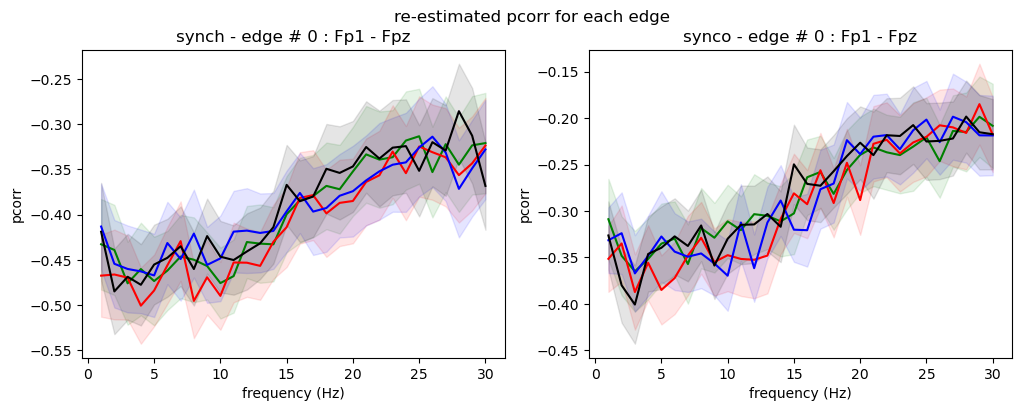

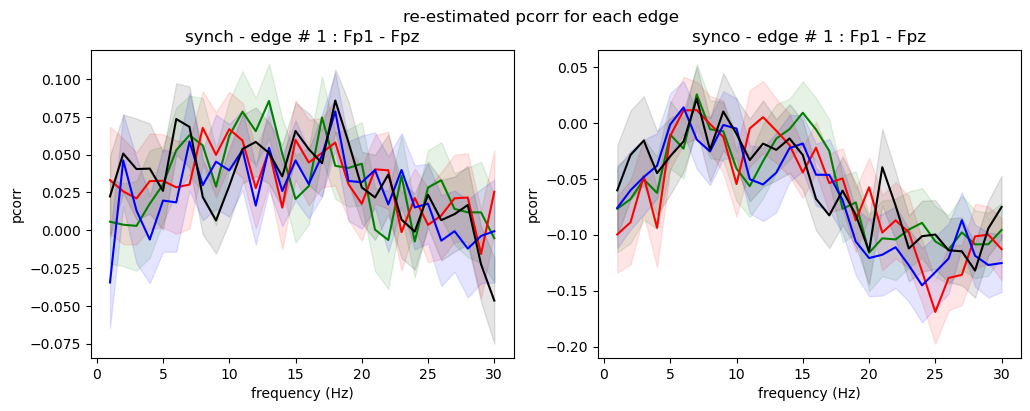

In [26]:
# plot each edge

# examine each of the 32*31/2 = 496 edges
# note that each freq has diff num of edges

# visualization of parcor in selection of edge


n=0
for i in range(32):
    for j in range (32):
        if i<j: # upper half of the matrix
            while n < 496:
                fig, ax = plt.subplots(1,2,figsize=(4*2+4, 4))
                for syn in range(2):
                    plt.sca(ax[syn])             
                    for condi in range(4):
                        plt.plot (np.arange(30)+1,mean30f_syn_4condi[syn][condi][n],color=color_4st[condi])
                        plt.fill_between(np.arange(30)+1,mean30f_syn_4condi[syn][condi][n]-sem30f_sem_syn_4condi[syn][condi][n],\
                        mean30f_syn_4condi[syn][condi][n]+sem30f_sem_syn_4condi[syn][condi][n],\
                            color=color_4st[condi], alpha=.1)
                        plt.xlabel("frequency (Hz)")
                        plt.ylabel("pcorr")
                    plt.title(syn2names[syn] + ' - edge # ' + str(n) +\
                            ' : ' + labels[i] + ' - ' + labels[j])
                fig.suptitle('re-estimated pcorr for each edge')
                n += 1


# # print into Pdf file
# paffilename = "re_pcorr_496edges.pdf"
# save_image(paffilename)

In [23]:
n

496

sum strength of edges

In [17]:
# # compute sum strength of edges in each trial 
# #  re_parcor_all into 4 conditions in 2 syn types
# # append all trials of the same condition together
# sumedge_synch_Uncoupled = [[] for i in range(30)]
# sumedge_synch_Leading   = [[] for i in range(30)]
# sumedge_synch_Following = [[] for i in range(30)]
# sumedge_synch_Mutual    = [[] for i in range(30)]

# sumedge_synco_Uncoupled = [[] for i in range(30)]
# sumedge_synco_Leading   = [[] for i in range(30)]
# sumedge_synco_Following = [[] for i in range(30)]
# sumedge_synco_Mutual    = [[] for i in range(30)]


# for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
#     for subj in range(2):
#         for trl in range(3):
#             for freq in range(30):
#                 if subj == 0:
#                     sumedge_synch_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl])   ,subj,freq,:,:]))-32)/2)
#                     sumedge_synch_Leading   [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synch_Following [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synch_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                 else:
#                     sumedge_synch_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl])   ,subj,freq,:,:]))-32)/2)
#                     sumedge_synch_Leading   [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synch_Following [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synch_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)

# for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
#     for subj in range(2):
#         for trl in range(3):
#             for freq in range(30):
#                 if subj == 0:
#                     sumedge_synco_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl])   ,subj,freq,:,:]))-32)/2)
#                     sumedge_synco_Leading   [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synco_Following [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synco_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                 else:
#                     sumedge_synco_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl])   ,subj,freq,:,:]))-32)/2)
#                     sumedge_synco_Leading   [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synco_Following [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)
#                     sumedge_synco_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl])      ,subj,freq,:,:]))-32)/2)

In [18]:
# # mean of the number of edges in each frequency
# sumedge_mean_synch_Uncoupled = np.zeros((30))
# sumedge_mean_synch_Leading   = np.zeros((30))
# sumedge_mean_synch_Following = np.zeros((30))
# sumedge_mean_synch_Mutual    = np.zeros((30))

# sumedge_mean_synco_Uncoupled = np.zeros((30))
# sumedge_mean_synco_Leading   = np.zeros((30))
# sumedge_mean_synco_Following = np.zeros((30))
# sumedge_mean_synco_Mutual    = np.zeros((30))

# for freq in range(30):
#     sumedge_mean_synch_Uncoupled[freq] = (np.asarray(sumedge_synch_Uncoupled[freq])).mean(0)
#     sumedge_mean_synch_Leading[freq]   = (np.asarray(sumedge_synch_Leading  [freq])).mean(0)
#     sumedge_mean_synch_Following[freq] = (np.asarray(sumedge_synch_Following[freq])).mean(0)
#     sumedge_mean_synch_Mutual[freq]    = (np.asarray(sumedge_synch_Mutual   [freq])).mean(0)

#     sumedge_mean_synco_Uncoupled[freq] = (np.asarray(sumedge_synco_Uncoupled[freq])).mean(0)
#     sumedge_mean_synco_Leading[freq]   = (np.asarray(sumedge_synco_Leading  [freq])).mean(0)
#     sumedge_mean_synco_Following[freq] = (np.asarray(sumedge_synco_Following[freq])).mean(0)
#     sumedge_mean_synco_Mutual[freq]    = (np.asarray(sumedge_synco_Mutual   [freq])).mean(0)

In [19]:
# # sem of the number of edges in each frequency
# sumedge_sem_synch_Uncoupled = np.zeros((30))
# sumedge_sem_synch_Leading   = np.zeros((30))
# sumedge_sem_synch_Following = np.zeros((30))
# sumedge_sem_synch_Mutual    = np.zeros((30))

# sumedge_sem_synco_Uncoupled = np.zeros((30))
# sumedge_sem_synco_Leading   = np.zeros((30))
# sumedge_sem_synco_Following = np.zeros((30))
# sumedge_sem_synco_Mutual    = np.zeros((30))

# for freq in range(30):
#     sumedge_sem_synch_Uncoupled[freq] = sem(np.asarray(sumedge_synch_Uncoupled[freq]))
#     sumedge_sem_synch_Leading[freq]   = sem(np.asarray(sumedge_synch_Leading  [freq]))
#     sumedge_sem_synch_Following[freq] = sem(np.asarray(sumedge_synch_Following[freq]))
#     sumedge_sem_synch_Mutual[freq]    = sem(np.asarray(sumedge_synch_Mutual   [freq]))

#     sumedge_sem_synco_Uncoupled[freq] = sem(np.asarray(sumedge_synco_Uncoupled[freq]))
#     sumedge_sem_synco_Leading[freq]   = sem(np.asarray(sumedge_synco_Leading  [freq]))
#     sumedge_sem_synco_Following[freq] = sem(np.asarray(sumedge_synco_Following[freq]))
#     sumedge_sem_synco_Mutual[freq]    = sem(np.asarray(sumedge_synco_Mutual   [freq]))

In [20]:
# sumedge_mean_synch_4condi=[sumedge_mean_synch_Uncoupled, 
#                            sumedge_mean_synch_Leading, 
#                            sumedge_mean_synch_Following, 
#                            sumedge_mean_synch_Mutual]
# sumedge_mean_synco_4condi=[sumedge_mean_synco_Uncoupled, 
#                            sumedge_mean_synco_Leading, 
#                            sumedge_mean_synco_Following, 
#                            sumedge_mean_synco_Mutual]
# sumedge_mean_syn_4condi=[sumedge_mean_synch_4condi,
#                          sumedge_mean_synco_4condi]

# sumedge_sem_synch_4condi=[sumedge_sem_synch_Uncoupled,  
#                           sumedge_sem_synch_Leading,
#                           sumedge_sem_synch_Following, 
#                           sumedge_sem_synch_Mutual]
# sumedge_sem_synco_4condi=[sumedge_sem_synco_Uncoupled,  
#                           sumedge_sem_synco_Leading,
#                           sumedge_sem_synco_Following, 
#                           sumedge_sem_synco_Mutual]
# sumedge_sem_syn_4condi=[sumedge_sem_synch_4condi,
#                         sumedge_sem_synco_4condi]

Text(0.5, 0.98, 'average sum of edge strength')

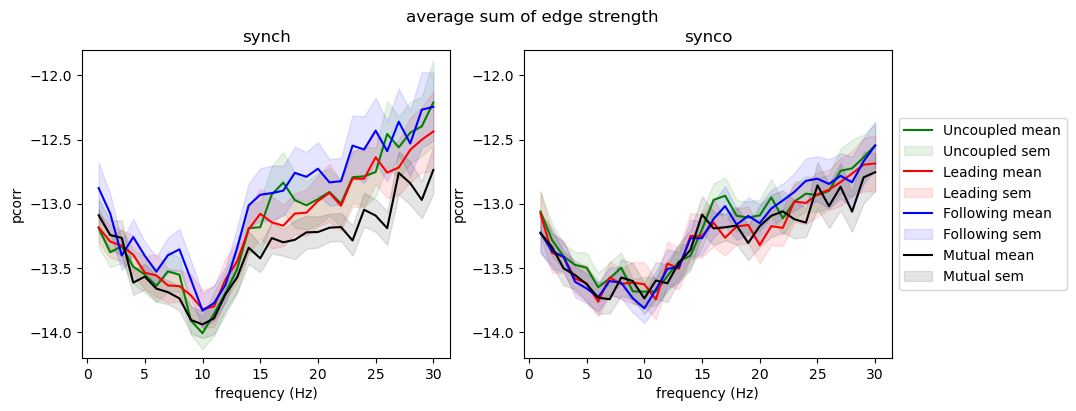

In [21]:
# # visualization of parcor selection in 2 synch types 4 conditions
# syn2names=['synch','synco']
# states4names=['Uncoupled','Leading','Following','Mutual']
# color_4st=['green','red','blue','black']
# fig, ax = plt.subplots(1,2,figsize=(4*2+4, 4))
# for syn in range(2):
# 	plt.sca(ax[syn])
# 	for condi in range(4):
# 			plt.plot (np.arange(30)+1,sumedge_mean_syn_4condi[syn][condi],color=color_4st[condi])
# 			plt.fill_between(np.arange(30)+1,sumedge_mean_syn_4condi[syn][condi]-sumedge_sem_syn_4condi[syn][condi],\
# 			sumedge_mean_syn_4condi[syn][condi]+sumedge_sem_syn_4condi[syn][condi],\
# 				color=color_4st[condi], alpha=.1)
# 			plt.xlabel("frequency (Hz)")
# 			plt.ylabel("pcorr")
# 			plt.ylim(-14.2,-11.8)
# 	plt.title(syn2names[syn])

# fig.subplots_adjust(right=0.8)
# plt.legend(['Uncoupled mean', 'Uncoupled sem', 'Leading mean', 'Leading sem',
#     'Following mean', 'Following sem','Mutual mean','Mutual sem'],ncol=1,
#     loc='center left', bbox_to_anchor=(1, 0.5))
# fig.suptitle('average sum of edge strength')

networkx

In [29]:
import networkx as nx

In [30]:
# construct edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [32]:
# load chan locs for topoplots
dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx
pos_mat=loadmat('../Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']

In [ ]:
# select a freq to investigate
for freq in range(30):

        fig, ax = plt.subplots(2,4,figsize=(6*4+3, 6*2))

        for syn in range(2):
                for condi in range(4):
                        weights=mean30f_syn_4condi[syn][condi][:,freq]
                        non0_edges=list()
                        for i in range(len(edges_list)): # 496
                                if weights[i] != 0:
                                        non0_edges.append(edges_list[i]+({'weight': weights[i]},))
                        # networkx initiate with edges
                        X = nx.Graph()
                        X.add_edges_from(non0_edges)
                        edges,non0_weights = zip(*nx.get_edge_attributes(X,'weight').items())

                        centrality = nx.current_flow_betweenness_centrality(X, weight='weight')
                        node_colors=[n for n in centrality.values()]

                        # set colorbar limits for node and edge from the 1st subplot
                        if syn==0 and condi ==0:
                                vmin_node_c=min(node_colors)+0.33*(max(node_colors)-min(node_colors))
                                vmax_node_c=max(node_colors)-0.33*(max(node_colors)-min(node_colors))
                                vmin_edge_c=min(weights)+0.5*(max(weights)-min(weights))
                                vmax_edge_c=max(weights)#-0.33*(max(weights)-min(weights))
                        
                        # subplot
                        plt.sca(ax[syn, condi])

                        nx.draw_networkx_labels(X, pos, labels=labeldict, font_size=10)

                        nodes=nx.draw_networkx_nodes(X, pos, node_size=500, 
                                node_color=node_colors, vmin=vmin_node_c, vmax=vmax_node_c, 
                                cmap='Greens', alpha=0.5)

                        edges=nx.draw_networkx_edges(X, pos, width=2, 
                                edge_color=non0_weights,edge_vmin=vmin_edge_c,edge_vmax=vmax_edge_c,
                                edge_cmap=plt.cm.jet,alpha=0.5)
                        
                        ax[syn, condi].set_title(syn2names[syn] + ' ' + states4names[condi],
                                                 fontsize = 20) 
                        ax[syn, condi].axis('off')

        fig.subplots_adjust(right=0.8)
        cbar_ax1 = fig.add_axes([0.83, 0.15, 0.01, 0.7])
        cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.7])

        cbar_node=fig.colorbar(nodes,cbar_ax1)
        cbar_node.ax.tick_params(labelsize=10)
        cbar_node.set_label('node (current_flow_betweenness_centrality)')

        cbar_edges=fig.colorbar(edges,cbar_ax2)
        cbar_edges.ax.tick_params(labelsize=10)
        cbar_edges.set_label('edge (average pcorr re-estimated)')

        fig.subplots_adjust(top=0.85)
        fig.suptitle('Freq: ' + str(freq+1) + ' Hz', fontsize = 20) 


# print into Pdf file
paffilename = "freq30_pcorr_networkx.pdf"
save_image(paffilename)